In [1]:
import warnings
warnings.filterwarnings("ignore")
import pylab as plt
import os.path as op
path_data = op.join(op.expanduser('~'), 'nilearn_data/')
%matplotlib inline

# Cross-validation in Neuroimaging
This notebook is a slight extension of the Haxby decoding tutorial...it focuses on a few cross-validation methods you might employ in your model fit, and covers some best practices.

First we will load/display the data we'll work with

In [2]:
from nilearn import datasets
from nilearn import plotting

# By default the 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby()
fmri_filename = haxby_dataset.func[0]

# print basic information on the dataset
print('First subject function Nifti images (4D) are at: %s' %fmri_filename)

First subject function Nifti images (4D) are at: C:\Users\jzm0144/nilearn_data\haxby2001\subj2\bold.nii.gz


E:\Janzaib_Masood\Anaconda\lib\site-packages\scipy\ndimage\measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
C:\Users\jzm0144\AppData\Roaming\Python\Python37\site-packages\nilearn\plotting\displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):


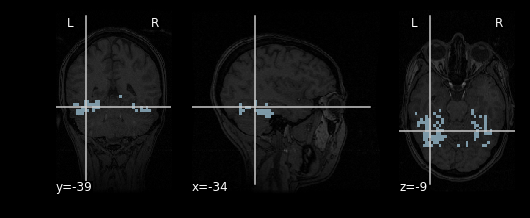

In [3]:
mask_filename = haxby_dataset.mask_vt[0]
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0], cmap='Paired')

Next we mask and vectorize the data

In [4]:
from nilearn.input_data import NiftiMasker
# Load the mask from the disk
masker = NiftiMasker(mask_img=mask_filename, standardize=True)

# Fitting the transformer intializes it to operate on new data
masker.fit(fmri_filename)

# Now we'll transform our fMRI data
fmri_masked = masker.transform(fmri_filename)

C:\Users\jzm0144\AppData\Roaming\Python\Python37\site-packages\nilearn\_utils\cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


The variable "fmri_masked" is a numpy array. It is 2D.

Its shape corresponds to the number of time-points x the number of voxels in the mask. Note that this is much fewer than the total number of voxels in the nifty image.

In [5]:
print(fmri_masked)

[[ 7.6757914e-01  2.3108709e+00 -2.0519446e-01 ... -1.0261141e+00
   8.7993503e-02  2.0720530e+00]
 [ 5.5640829e-01  1.6833442e+00 -2.4644940e-01 ... -7.0238096e-01
  -3.4570050e-01  2.0341012e+00]
 [ 7.6757914e-01  1.9186667e+00  1.0802227e-03 ... -9.9374086e-01
  -2.7630946e-01  2.1479564e+00]
 ...
 [-4.2905572e-01 -1.6896113e+00 -7.4150860e-01 ... -1.5440873e+00
   1.8054218e+00 -1.6709729e-01]
 [-1.4749458e-01 -1.8072726e+00 -2.4644940e-01 ... -1.7707006e+00
   1.5452055e+00  7.8169519e-01]
 [-2.1788488e-01 -1.4542887e+00  1.0802227e-03 ... -1.6412073e+00
   1.2676412e+00  8.9555031e-01]]


In [6]:
print(type(fmri_masked))
print(fmri_masked.shape)

<class 'numpy.ndarray'>
(1452, 464)


### Load the behavioral labels

Now we'll load the behavioral labels for this dataset.

In [7]:
import pandas as pd
import numpy as np

# Load target information as string and give a numerical identifier to each
labels = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
print(labels.head())

  labels  chunks
0   rest       0
1   rest       0
2   rest       0
3   rest       0
4   rest       0


E:\Janzaib_Masood\Anaconda\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


It looks like the labels has the same length as our fMRI data, meaning that they share the same time-base.

In [8]:
print(labels.shape)
print(fmri_masked.shape)

(1452, 2)
(1452, 464)


Next, we'll retrieve the behavioral targets from the labels. These will be the "classes" that we attempt to predict.

Note that these labels aren't integers like before. That's fine - sklearn will try to be clever and convert these into integer representations when we fit the model

In [9]:
print(labels['labels'].values[:50])

['rest' 'rest' 'rest' 'rest' 'rest' 'rest' 'scissors' 'scissors'
 'scissors' 'scissors' 'scissors' 'scissors' 'scissors' 'scissors'
 'scissors' 'rest' 'rest' 'rest' 'rest' 'rest' 'rest' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'rest' 'rest' 'rest' 'rest'
 'rest' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'rest'
 'rest' 'rest' 'rest' 'rest' 'shoe']


### Restrict the analysis to cats and faces

We'll take a subset of samples so that we're only including cats and faces classes...

In [13]:
# Create a mask with Pandas
condition_mask = labels.eval('labels in ["face", "cat"]').values

# Create a mask with numpy
# condition_mask = np.logical_or(target == b'face', target == b'cat')

# We apply this mask in the sample direction to restrict the
# classification to the face vs cat discrimination
fmri_masked = fmri_masked[condition_mask]
targets = labels[condition_mask]['labels'].values

Note that we now have fewer samples.

In [14]:
print(fmri_masked.shape)

(216, 464)


## Fit the Model
Finally, We will fit our model!!!!!

In [15]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
print(svc)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


As our data is already in the shape for sklearn, it's quite easy to fit the model.

In [16]:
svc.fit(fmri_masked, targets)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [17]:
prediction = svc.predict(fmri_masked)
print(prediction)

['face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face' '

### Validation
The proper way to measure error rates or prediction accuracy is via cross-validation: leaving out some data and testing on it. There are many ways to do this.

### ...by manually leaving out data
Let's leave out the 30 last data points during traning, and test the prediction on these 30 last points:


In [20]:
svc.fit(fmri_masked[:-30], targets[:-30])

prediction = svc.predict(fmri_masked[:-30])
print(np.sum(prediction == targets[-30:])  / float(len(targets[-30:])))

0.0


E:\Janzaib_Masood\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.



However, this seems unfortunate. We've now got 50% less data in order to fit the model. Ideally, we'd like to do two things:

    Validate our model properly (aka, on held-out data not used in model fitting)
    Use as much of our data as possible.


It is difficult to satisfy both of these conditions properly, but cross-validation is one way of getting closer to this goal.

### Cross-validation: Implementing a KFold loop
We can split the data in train and test set repetivtively in a KFold strategy. We'll create many cross-validation objects with sklearn.                       
When one iterates through these, it returns different indices for training/test sets upon each iteration.

Let's visualize what this will look like below...

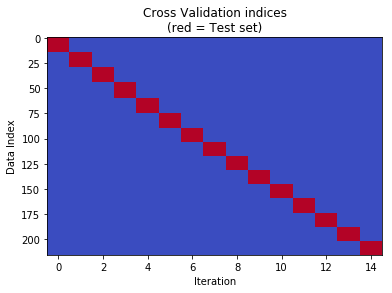

In [22]:
# Create a KFold object
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

n_splits = 15
cv = KFold(n_splits=n_splits)

cv_sample = np.zeros([len(fmri_masked), n_splits])
for ii, (tr, tt) in enumerate(cv.split(fmri_masked)):
    cv_sample[tt, ii] = 1
fig, ax = plt.subplots()
ax.imshow(cv_sample, cmap='coolwarm', aspect='auto', interpolation='nearest')
_ = ax.set(xlabel='Iteration', ylabel= 'Data Index',
          title='Cross Validation indices\n(red = Test set)')

In [23]:
for train, test in cv.split(fmri_masked):
    svc.fit(fmri_masked[train], targets[train])
    prediction = svc.predict(fmri_masked[test])
    print(accuracy_score(targets[test], prediction))

0.8
1.0
1.0
0.5333333333333333
0.6
0.8
0.8571428571428571
0.8571428571428571
0.5714285714285714
0.42857142857142855
0.9285714285714286
0.35714285714285715
0.9285714285714286
0.7142857142857143
0.42857142857142855


In [26]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(svc, fmri_masked, targets)
print(cv_score)

[0.59722222 0.80555556 0.55555556]


E:\Janzaib_Masood\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [27]:
cv_score = cross_val_score(svc, fmri_masked, targets,
                           cv=cv.split(fmri_masked))
print(cv_score)

[0.8        1.         1.         0.53333333 0.6        0.8
 0.85714286 0.85714286 0.57142857 0.42857143 0.92857143 0.35714286
 0.92857143 0.71428571 0.42857143]


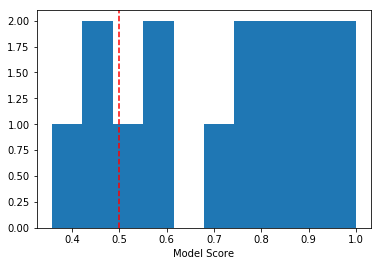

In [28]:
def plot_classifier_scores(scores):
    fig, ax = plt.subplots()
    ax.hist(scores)
    ax.axvline(.5, ls='--', c='r')
    ax.set_xlabel('Model Score')
plot_classifier_scores(cv_score)

In [30]:
# Find out list of session number
session_label = labels['chunks'][condition_mask]

# Iterate through sessions, validating on a held-out session
from sklearn.model_selection import LeaveOneLabelOut
cv = LeaveOneLabelOut(session_label)
cv_score = cross_val_score(svc, fmri_masked, targets, cv=cv)
plot_classifier_scores(cv_score)

ImportError: cannot import name 'LeaveOneLabelOut' from 'sklearn.model_selection' (E:\Janzaib_Masood\Anaconda\lib\site-packages\sklearn\model_selection\__init__.py)